In [92]:
import itertools
import math
import os

import gsd.hoomd
import hoomd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [93]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    central_color = fresnel.color.linear([252 / 255, 41 / 255, 0 / 255])
    constituent_color = fresnel.color.linear([93 / 255, 210 / 255, 252 / 255])

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=[0, 0, 0], roughness=0.5, primitive_color_mix=1.0
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.color[snapshot.particles.typeid[:] == 0] = central_color
    geometry.radius[snapshot.particles.typeid[:] == 0] = 0.3
    geometry.color[snapshot.particles.typeid[:] == 1] = constituent_color
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

A rigid body is an incompressible body composed of one central and one or more constituent particles. All particles in a given rigid body interact with all other particles in the simulation. In molecular dynamics simulations, the central particle translates and rotates in response to the net force and torque on the body. The constituent particles follow the central particle.

You define the positions and orientations of the constituent particles in body coordinates, a coordinate system where the (0,0,0) is at the position of the central particle and the body is in a reference orientation.

For example, define the positions of two points in a rigid dimer:

In [94]:
dimer_positions = [[-1.2, 0, 0], [1.2, 0, 0]]

Each instance of a rigid body in a simulation is placed in the system global coordinates, located by the position and orientation of the central particle.

In [95]:
central_position = [10, 5, 0]
central_rotation = 0.9

To demonstrate, the following code block computes the global positions of the dimer at the given central position and rotation (in 2D).

In [96]:
cos_theta = math.cos(central_rotation)
sin_theta = math.sin(central_rotation)

global_positions = []
for i in range(len(dimer_positions)):
    x, y = dimer_positions[i][:2]

    global_positions.append(
        [
            [central_position[0] + (x * cos_theta - y * sin_theta)],
            [central_position[1] + (y * cos_theta + x * sin_theta)],
        ]
    )

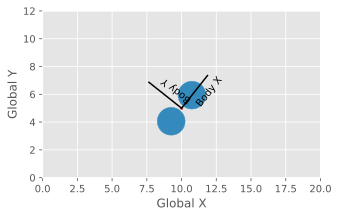

In [97]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09), dpi=100)
ax = fig.add_subplot(aspect="equal")

ax.plot(
    [central_position[0], central_position[0] - 3 * sin_theta],
    [central_position[1], central_position[1] + 3 * cos_theta],
    color="k",
)

ax.plot(
    [central_position[0], central_position[0] + 3 * cos_theta],
    [central_position[1], central_position[1] + 3 * sin_theta],
    color="k",
)

ax.text(
    central_position[0] + 1.5 * cos_theta,
    central_position[1] + 1.5 * sin_theta,
    "Body X",
    rotation=central_rotation * 180 / math.pi,
    verticalalignment="center",
)

ax.text(
    central_position[0] - 2 * sin_theta,
    central_position[1] + 2 * cos_theta,
    "Body Y",
    rotation=central_rotation * 180 / math.pi + 90,
    verticalalignment="center",
)

ax.add_patch(
    matplotlib.patches.Circle(
        (central_position[0], central_position[1]), 0.1, color="C0"
    )
)

for position in global_positions:
    ax.add_patch(matplotlib.patches.Circle((position[0], position[1]), 1.0, color="C1"))

ax.set_xlim(0, 20)
ax.set_ylim(0, 12)

ax.set_xlabel("Global X")
ax.set_ylabel("Global Y")

fig

The following rigid body properties are given by the properties of the central particle:

Mass - the total mass of the rigid body.
Moment of inertia tensor - how mass is distributed throughout the rigid body.
Velocity - velocity of the center of mass of the rigid body.
Angular momentum - angular momentum of the rigid body.
Position - the position in global coordinates. Example: position = [1, 2, -3]
Orientation - a quaternion that rotates) the rigid body about the central particle. Example: orientation = [1, 0, 0, 0]
The following constituent particle properties are given by the properties of a given rigid body type:

Constituent Particle Positions - The vector from the center of the rigid body to the constituent particle in body coordinates.
Constituent Particle Orientation - A quaternion that rotates the constituent particle about its center.

Let each constituent particle in the dimer be a point particle of type A with mass 1 at the constituent positions previously defined in dimer_positions. Each dimer will be located at the position of a particle of type dimer.

Let's create an initial configuration of dimers. Start with a frame containing both particle types:

In [98]:
frame = gsd.hoomd.Frame()
frame.particles.types = ["dimer", "A"]

In [99]:
m = 4
N_particles = m**3
spacing = 5
K = math.ceil(N_particles ** (1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = numpy.array(position) + [spacing / 2, spacing / 2, spacing / 2]
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles, :]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]

With two particles of mass 1, the total mass of the body is 2. Set the mass of each instance of the body:

In [100]:
frame.particles.mass = [2] * N_particles

The moment of inertia of a point particle about a given axis is given by, I = mr^2 where 
r is the distance of the point from the axis. More generally, the moment of inertia is a tensor and includes off-diagonal values (you will learn more about this in a later tutorial section).

Compute the moment of inertia of the dimer:

In [101]:
mass = 1
I = numpy.zeros(shape=(3, 3))
for r in dimer_positions:
    I += mass * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))
I

array([[0.  , 0.  , 0.  ],
       [0.  , 2.88, 0.  ],
       [0.  , 0.  , 2.88]])

In this case, the tensor is diagonal. This is important as HOOMD-blue assumes that bodies have a diagonal moment of inertia in body coordinates in the form: 
[Ixx, Iyy, Izz]. Set the moments of inertia of each body in the snapshot:

In [102]:
frame.particles.moment_inertia = [I[0, 0], I[1, 1], I[2, 2]] * N_particles

Notice that Ixx is zero for this dimer while Iyy and Izz
 are non-zero. HOOMD-blue checks which moments of inertia are non-zero and integrates degrees of freedom only for those axes with non-zero moments of inertia. In this example, the dimer will rotate about the body's y and z axes, but not x.

HOOMD-blue represents orientations with quaternions. The quaternion [1, 0, 0] is the identity. Set the orientation of each body in the snapshot to the identity:

In [103]:
frame.particles.orientation = [(1, 0, 0, 0)] * N_particles

Write the rigid centers to a GSD file for later use:

In [104]:
# Some file checking, if the file exists, remove it
if(os.path.exists("/home/user/sticky_particles/snapshots/dimer_centers.gsd")):
    os.remove("/home/user/sticky_particles/snapshots/dimer_centers.gsd")

with gsd.hoomd.open(name="/home/user/sticky_particles/snapshots/dimer_centers.gsd", mode="x") as f:
    f.append(frame)

The hoomd.md.constrain.Rigid class is responsible for applying the rigid body constraints:

In [105]:
rigid = hoomd.md.constrain.Rigid()

Set the constituent particle properties in body coordinates for the rigid body type:

In [106]:
rigid.body["dimer"] = {
    "constituent_types": ["A", "A"],
    "positions": dimer_positions,
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)],
}

Rigid will use the body definition to update particle type, positions, and orientations each time step.
The current simulation state has only the central particles with type dimer:

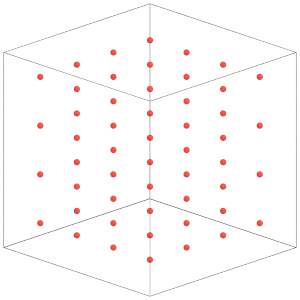

In [107]:
simulation = hoomd.Simulation(device=hoomd.device.CPU(), seed=4)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/dimer_centers.gsd")
render(simulation.state.get_snapshot())

Rigid.create_bodies will place constituent particles in the simulation state:

In [108]:
rigid.create_bodies(simulation.state)

Each central particle now has the two constituent particles of the dimer placed around it:

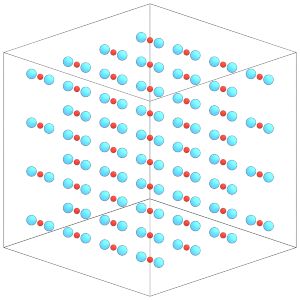

In [109]:
render(simulation.state.get_snapshot())

Understand that Rigid will overwrite the positions and orientations of the constituent particles in the simulation state. To demonstrate, let's modify the positions of the constituents:

In [110]:
with simulation.state.cpu_local_snapshot as snapshot:
    typeid = snapshot.particles.typeid
    snapshot.particles.position[typeid == 1] = [0, 0, 0]

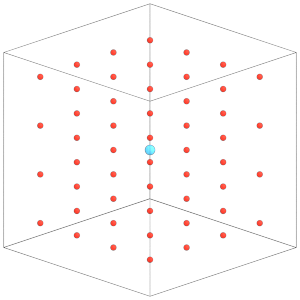

In [111]:
render(simulation.state.get_snapshot())

Apply rigid constraint during MD integration:

In [112]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
integrator.rigid = rigid
simulation.operations.integrator = integrator

Rigid will apply the rigid body constraints at the start of a simulation run and on every timestep. Calling simulation.run(0) will restore the constituent particle positions:

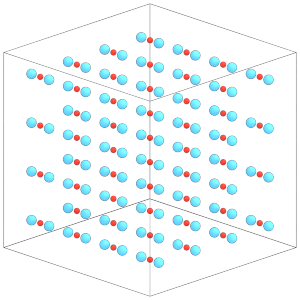

In [113]:
simulation.run(0)
render(simulation.state.get_snapshot())

To change the position or orientation of a given body, change the properties of the central particle:

In [114]:
with simulation.state.cpu_local_snapshot as snapshot:
    typeid = snapshot.particles.typeid
    snapshot.particles.orientation[typeid == 0] = [0.70710678, 0.0, 0.70710678, 0.0]

Again, execute simulation.run(0) for the changes to take effect on the constituent particles.

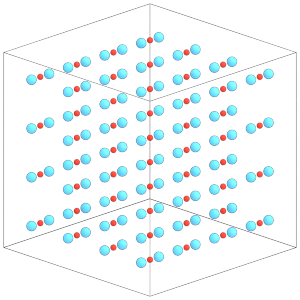

In [115]:
simulation.run(0)
render(simulation.state.get_snapshot())

In [116]:
# Some file checking, if the file exists, remove it
if(os.path.exists("/home/user/sticky_particles/snapshots/dimer_lattice.gsd")):
    os.remove("/home/user/sticky_particles/snapshots/dimer_lattice.gsd")

hoomd.write.GSD.write(state=simulation.state, mode="xb", filename="/home/user/sticky_particles/snapshots/dimer_lattice.gsd")

the first two particles in the state are central particle

In [117]:
snapshot = simulation.state.get_snapshot()
print(snapshot.particles.body[0:2])

[0 1]


create_bodies added their constituents to the end:

In [118]:
print(snapshot.particles.body[N_particles : N_particles + 4])

[0 0 1 1]
